
# ***Data Aquisition***

In [ ]:
! pip install -q kaggle

In [ ]:
 from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"atharvamusale01","key":"f754ec3324cc03e5dba0d99cfb916202"}'}

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle competitions download -c jigsaw-toxic-comment-classification-challenge

  0% 0.00/1.46M [00:00<?, ?B/s]
100% 1.46M/1.46M [00:00<00:00, 48.1MB/s]
 68% 18.0M/26.3M [00:00<00:00, 72.4MB/s]
100% 26.3M/26.3M [00:00<00:00, 87.7MB/s]
  0% 0.00/1.39M [00:00<?, ?B/s]
100% 1.39M/1.39M [00:00<00:00, 95.7MB/s]
 55% 13.0M/23.4M [00:00<00:00, 16.9MB/s]
100% 23.4M/23.4M [00:01<00:00, 24.2MB/s]


In [ ]:
!unzip /content/train.csv.zip
!unzip /content/test.csv.zip
!unzip /content/sample_submission.csv

Archive:  /content/train.csv.zip
  inflating: train.csv               
Archive:  /content/test.csv.zip
  inflating: test.csv                
Archive:  /content/sample_submission.csv.zip
  inflating: sample_submission.csv   


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re

import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import RandomizedSearchCV,train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score,roc_auc_score,confusion_matrix,accuracy_score
from sklearn.neighbors import KNeighborsClassifier

import tensorflow as tf
from math import ceil
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from prettytable import PrettyTable
from keras.utils import to_categorical
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Input, Dense, Flatten, LSTM,Dropout, concatenate,\
Conv1D,BatchNormalization,SpatialDropout1D,Bidirectional,GRU,GlobalAveragePooling1D,GlobalMaxPooling1D
from tensorflow.keras import regularizers,initializers,optimizers,Model
from tensorflow.keras.callbacks import Callback, ModelCheckpoint,EarlyStopping



# **EDA**

In [ ]:
data = pd.read_csv('/content/train.csv')
data_test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')

In [ ]:
print(data.shape)
print(data_test.shape)
print(submission.shape)

(159571, 8)
(153164, 2)
(153164, 7)


In [ ]:
"""Lets get the idea of the training data we have..."""
data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [ ]:
data.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [ ]:
"""Lets take a general information about test data..."""
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153164 entries, 0 to 153163
Data columns (total 2 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            153164 non-null  object
 1   comment_text  153164 non-null  object
dtypes: object(2)
memory usage: 2.3+ MB


In [ ]:
"""
From the above description we can see that the mean value of \
each class is way too low, its below 0.1 that means there must be very few\
comments which are toxic in nature. So I am making a dataframe of the toxic \
comments only and lets see how many of the whole comments are actually toxic.
"""
labelled_in_all = data[(data['toxic']==1) | (data['severe_toxic']==1) | (data['obscene']==1) |
                            (data['threat']==1) | (data['insult']==1) | (data['identity_hate']==1)]

In [ ]:
labelled_in_all

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
12,0005c987bdfc9d4b,Hey... what is it..\n@ | talk .\nWhat is it......,1,0,0,0,0,0
16,0007e25b2121310b,"Bye! \n\nDon't look, come or think of comming ...",1,0,0,0,0,0
42,001810bf8c45bf5f,You are gay or antisemmitian? \n\nArchangel WH...,1,0,1,0,1,1
43,00190820581d90ce,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1,0,1,0,1,0
...,...,...,...,...,...,...,...,...
159494,fef4cf7ba0012866,"""\n\n our previous conversation \n\nyou fuckin...",1,0,1,0,1,1
159514,ff39a2895fc3b40e,YOU ARE A MISCHIEVIOUS PUBIC HAIR,1,0,0,0,1,0
159541,ffa33d3122b599d6,Your absurd edits \n\nYour absurd edits on gre...,1,0,1,0,1,0
159546,ffb47123b2d82762,"""\n\nHey listen don't you ever!!!! Delete my e...",1,0,0,0,1,0


In [ ]:
print('Total Percentage of toxic comments in whole data is: {}'.format(len(labelled_in_all)/len(data)*100))

Total Percentage of toxic comments in whole data is: 10.167887648758233


In [ ]:
data.isnull().any()

id               False
comment_text     False
toxic            False
severe_toxic     False
obscene          False
threat           False
insult           False
identity_hate    False
dtype: bool

**We can see that there is no missing data. That's great!!!. So now lets check the distribution of the lengths of the comments.**

In [ ]:
data['char_length'] = data['comment_text'].apply(lambda x: len(str(x)))

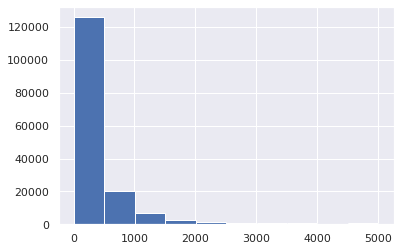

In [ ]:
sns.set()
data['char_length'].hist()
plt.show()

**We can see that most of the comments are below 2500 characters. Now next part is when we look at the counts of the output classes**

In [ ]:
comment_text_count=0
toxic_count=0
severe_toxic_count=0
obscene_count=0
threat_count=0
insult_count=0
identity_hate_count=0

In [ ]:
labelled_in_all = labelled_in_all.reset_index(drop=True)

In [ ]:
for i in range(len(data)):
  if data['toxic'][i]==1:
    toxic_count+=1
  if data['severe_toxic'][i]==1:
    severe_toxic_count+=1
  if data['obscene'][i]==1:
    obscene_count+=1
  if data['threat'][i]==1:
    threat_count+=1
  if data['insult'][i]==1:
    insult_count+=1
  if data['identity_hate'][i]==1:
    identity_hate_count+=1  

In [ ]:
counts = [toxic_count,severe_toxic_count,obscene_count,threat_count,insult_count,identity_hate_count]
target = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']
counts_df = pd.DataFrame(data=target,columns=['type'])
counts_df['counts']=counts

In [ ]:
counts_df

,type,counts
0,toxic,15294
1,severe_toxic,1595
2,obscene,8449
3,threat,478
4,insult,7877
5,identity_hate,1405


We can see that most of the comments belong to toxic followed by obscene, insult, severe_toxic, identity_hate, threat

In [ ]:
corr_data = data[target]

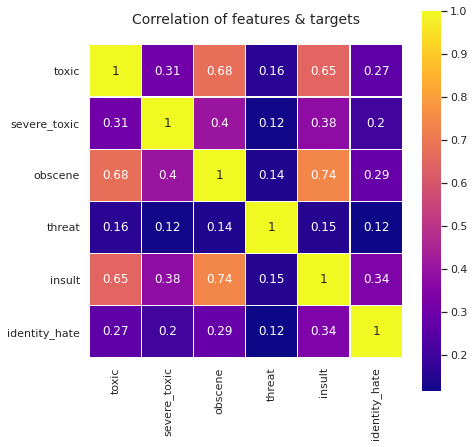

In [ ]:
colormap = plt.cm.plasma
plt.figure(figsize=(7,7))
plt.title('Correlation of features & targets',y=1.05,size=14)
sns.heatmap(corr_data.astype(float).corr(),linewidths=0.1,vmax=1.0,square=True,cmap=colormap,
           linecolor='white',annot=True)

# **Data Preprocessing**

In [ ]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = re.sub('[0-9]', '', text)
    text = text.strip(' ')
    return text

In [ ]:
# clean the comment_text in train_df 
data['comment_text'] = data['comment_text'].map(lambda com : clean_text(com))

In [ ]:
# lets take a look at few points
for i in range(10):
  n = np.random.randint(low=0,high=20000)
  print(data['comment_text'][n])
  print('#'*200)

please do not vandalize pages as you did with this edit to list of rulers named henry if you continue to do so you will be blocked from editing
########################################################################################################################################################################################################
hi hi there i just wanted to know how you know that new page requires categorization talk
########################################################################################################################################################################################################
please do not disrupt wikipedia to make a point or a joke your accusations of racism against griswaldo and maunus are offensive nonsense they are good editors of wikipedia who deserve respect if you insult them or others further you will be blocked or banned sharktopustalk
##########################################################################################

In [ ]:
data = data.drop(columns=['char_length'])

In [ ]:
X = data.comment_text

# **TFIDF Vectorization**

In [ ]:
# I am using this vectorizarion strategy to get the vectors for text in the comments
vect = TfidfVectorizer(max_features=5000,stop_words='english')
vect

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=5000,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words='english', strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [ ]:
# learn the vocabulary in the training data, then use it to create a document-term matrix
X_dtm = vect.fit_transform(X)
X_dtm

<159571x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 3103824 stored elements in Compressed Sparse Row format>

In [ ]:
test = pd.read_csv('test.csv')

In [ ]:
test.shape

(153164, 2)

In [ ]:
test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [ ]:
test['comment_text'] = test['comment_text'].map(lambda x: clean_text(x))

In [ ]:
X_test = [test['comment_text'][0]]
Xvdm_test = vect.transform(X_test)

In [ ]:
X_test = test['comment_text']
Xvdm_test = vect.transform(X_test)

In [ ]:
Xvdm_test

<153164x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 2592170 stored elements in Compressed Sparse Row format>

# **Ligistic Regression**

In [ ]:
""" 
Hyperparameter Tuning for C: 
"""



a = [0.001,0.01,0.1,1,10]
for i in a:
  avg=[]
  max_avg = []
  print('for C= :',i)
  logreg = LogisticRegression(C=i)

  # create submission file
  # submission_binary = pd.read_csv('sample_submission.csv')

  for label in target:
      print('... Processing {}'.format(label))
      y = data[label]
      # train the model using X_dtm & y
      logreg.fit(X_dtm, y)
      # compute the training accuracy
      y_pred_X = logreg.predict(X_dtm)
      print('Training accuracy is {}'.format(accuracy_score(y, y_pred_X)))
      avg.append(accuracy_score(y, y_pred_X))
      # compute the predicted probabilities for X_test_dtm
      test_y_prob = logreg.predict_proba(Xvdm_test)[:,1]
  print('Avg accuracy across all classes is:',np.mean(avg))
  print('#'*200)

for C= : 0.001
... Processing toxic
Training accuracy is 0.9041555169799024
... Processing severe_toxic
Training accuracy is 0.9900044494300343
... Processing obscene
Training accuracy is 0.947051782592075
... Processing threat
Training accuracy is 0.9970044682304429
... Processing insult
Training accuracy is 0.9506363938309592
... Processing identity_hate
Training accuracy is 0.9911951419744189
Avg accuracy across all classes is: 0.9633412921729722
########################################################################################################################################################################################################
for C= : 0.01
... Processing toxic
Training accuracy is 0.9137938597865527
... Processing severe_toxic
Training accuracy is 0.9900044494300343
... Processing obscene
Training accuracy is 0.9524412330561317
... Processing threat
Training accuracy is 0.9970044682304429
... Processing insult
Training accuracy is 0.9525415019019746
... Processing 

In [ ]:
'''
We can see that the best value of C is 10
'''
logreg = LogisticRegression(C=10)

# create submission file
submission_binary = pd.read_csv('sample_submission.csv')

for label in target:
    print('... Processing {}'.format(label))
    y = data[label]
    # train the model using X_dtm & y
    logreg.fit(X_dtm, y)
    # compute the training accuracy
    y_pred_X = logreg.predict(X_dtm)
    print('Training accuracy is {}'.format(accuracy_score(y, y_pred_X)))
    print('Training F1 score is {}'.format(f1_score(y,(y_pred_X))))
    print('Training roc_auc_score is {}'.format(roc_auc_score(y,y_pred_X)))
    print('Confusion matri for {} is \n{}'.format(label, confusion_matrix(y,y_pred_X)))
  
    # compute the predicted probabilities for X_test_dtm
    test_y_prob = logreg.predict_proba(Xvdm_test)[:,1]
    submission_binary[label] = test_y_prob


... Processing toxic
Training accuracy is 0.9636274761704821
Training F1 score is 0.7873836911129022
Training roc_auc_score is 0.8469907297464394
Confusion matri for toxic is 
[[143020   1257]
 [  4547  10747]]
... Processing severe_toxic
Training accuracy is 0.9919032906981845
Training F1 score is 0.4691865242399343
Training roc_auc_score is 0.6781486350928589
Confusion matri for severe_toxic is 
[[157708    268]
 [  1024    571]]
... Processing obscene
Training accuracy is 0.9832613695470982
Training F1 score is 0.8277552073257238
Training roc_auc_score is 0.8776907668580393
Confusion matri for obscene is 
[[150482    640]
 [  2031   6418]]
... Processing threat
Training accuracy is 0.9979695558716809
Training F1 score is 0.5410764872521248
Training roc_auc_score is 0.6996745107931002
Confusion matri for threat is 
[[159056     37]
 [   287    191]]
... Processing insult
Training accuracy is 0.9754278659656204
Training F1 score is 0.7180151024811218
Training roc_auc_score is 0.813457

In [ ]:
submission_binary.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.999948,0.479776,0.999943,0.056418,0.966759,0.380413
1,0000247867823ef7,0.002899,0.000451,0.000492,0.000408,0.002889,0.000651
2,00013b17ad220c46,0.012997,0.000137,0.002835,0.000050,0.007571,0.001480
3,00017563c3f7919a,0.000999,0.002145,0.001114,0.000127,0.001220,0.000036
4,00017695ad8997eb,0.020477,0.000637,0.001448,0.000553,0.003553,0.000594


In [ ]:
import joblib
# save model
joblib.dump(logreg, '/content/drive/MyDrive/Toxic_Comment_Detection/Logistic/logistic.pkl')
# load model
gbm_pickle = joblib.load('/content/drive/MyDrive/Toxic_Comment_Detection/Logistic/logistic.pkl')

In [ ]:
submission_binary.to_csv('/content/drive/MyDrive/Toxic_Comment_Detection/Logistic/submission_combined.csv', index=False)

# **Naive Bayes**

In [ ]:
"""
Hyperparamter Tuning For alpha in Naive Bayes
"""
a = [0.001,0.01,0.1,1,10]
for i in a:
  avg=[]
  max_avg = []
  print('for alpha= :',i)
  nb = MultinomialNB(alpha=i)

  # create submission file
  # submission_binary = pd.read_csv('sample_submission.csv')

  for label in target:
      print('... Processing {}'.format(label))
      y = data[label]
      # train the model using X_dtm & y
      nb.fit(X_dtm, y)
      # compute the training accuracy
      y_pred_X = nb.predict(X_dtm)
      print('Training accuracy is {}'.format(accuracy_score(y, y_pred_X)))
      avg.append(accuracy_score(y, y_pred_X))
      # compute the predicted probabilities for X_test_dtm
      test_y_prob = nb.predict_proba(Xvdm_test)[:,1]
  print('Avg accuracy across all classes is:',np.mean(avg))
  print('#'*200)
  

for alpha= : 0.001
... Processing toxic
Training accuracy is 0.9527420395936606
... Processing severe_toxic
Training accuracy is 0.9901172518816076
... Processing obscene
Training accuracy is 0.9752962631054515
... Processing threat
Training accuracy is 0.9972802075565109
... Processing insult
Training accuracy is 0.9702890876161708
... Processing identity_hate
Training accuracy is 0.9914458140890262
Avg accuracy across all classes is: 0.979528443973738
########################################################################################################################################################################################################
for alpha= : 0.01
... Processing toxic
Training accuracy is 0.952723239185065
... Processing severe_toxic
Training accuracy is 0.990029516641495
... Processing obscene
Training accuracy is 0.9753087967111819
... Processing threat
Training accuracy is 0.9971987391192635
... Processing insult
Training accuracy is 0.9702452199961146
... Proce

In [ ]:
"""We can see that the alpha=0.001 So lets use it for prediction"""
nb = MultinomialNB(alpha=0.001)

  # create submission file
submission_binary = pd.read_csv('sample_submission.csv')

for label in target:
    print('... Processing {}'.format(label))
    y = data[label]
    # train the model using X_dtm & y
    nb.fit(X_dtm, y)
    # compute the training accuracy
    y_pred_X = nb.predict(X_dtm)
    print('Training accuracy is {}'.format(accuracy_score(y, y_pred_X)))
    print('Training F1 score is {}'.format(f1_score(y,(y_pred_X))))
    print('Training roc_auc_score is {}'.format(roc_auc_score(y,y_pred_X)))
    print('Confusion matri for {} is \n{}'.format(label, confusion_matrix(y,y_pred_X)))
    # compute the predicted probabilities for X_test_dtm
    test_y_prob = nb.predict_proba(Xvdm_test)[:,1]
    submission_binary[label] = test_y_prob
  

... Processing toxic
Training accuracy is 0.9527420395936606
Training F1 score is 0.692968527340092
Training roc_auc_score is 0.7755902527954986
Confusion matri for toxic is 
[[143520    757]
 [  6784   8510]]
... Processing severe_toxic
Training accuracy is 0.9901172518816076
Training F1 score is 0.5033070866141732
Training roc_auc_score is 0.7479983249707547
Confusion matri for severe_toxic is 
[[157195    781]
 [   796    799]]
... Processing obscene
Training accuracy is 0.9752962631054515
Training F1 score is 0.7261739372047792
Training roc_auc_score is 0.8069443662364209
Confusion matri for obscene is 
[[150402    720]
 [  3222   5227]]
... Processing threat
Training accuracy is 0.9972802075565109
Training F1 score is 0.42133333333333334
Training roc_auc_score is 0.664913685521747
Confusion matri for threat is 
[[158979    114]
 [   320    158]]
... Processing insult
Training accuracy is 0.9702890876161708
Training F1 score is 0.641186710058276
Training roc_auc_score is 0.76525837

In [ ]:
import joblib
# save model
joblib.dump(nb, '/content/drive/MyDrive/Toxic_Comment_Detection/Naive_Bayes/nb.pkl')
# load model
gbm_pickle = joblib.load('/content/drive/MyDrive/Toxic_Comment_Detection/Naive_Bayes/nb.pkl')

In [ ]:
submission_binary.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.998627,0.878147,0.996775,2.372294e-01,0.989563,0.841138
1,0000247867823ef7,0.012363,0.000002,0.003867,3.569641e-07,0.003718,0.000003
2,00013b17ad220c46,0.028675,0.000647,0.012447,1.068532e-06,0.012183,0.001823
3,00017563c3f7919a,0.006403,0.000023,0.002412,8.629114e-08,0.002327,0.000027
4,00017695ad8997eb,0.043885,0.001958,0.019780,6.718786e-04,0.017668,0.001675


In [ ]:
submission_binary.to_csv('/content/drive/MyDrive/Toxic_Comment_Detection/Naive_Bayes/submission_combined.csv', index=False)

# **Decision Tree**

In [ ]:
"""
Hyperparatmeter Tuning For max_depth in Decision Tree 
"""
a = [1,10,100]
for i in a:
  avg=[]
  max_avg = []
  print('for max_depth= :',i)
  dt = DecisionTreeClassifier(max_depth=i)

  # create submission file
  # submission_binary = pd.read_csv('sample_submission.csv')

  for label in target:
      print('... Processing {}'.format(label))
      y = data[label]
      # train the model using X_dtm & y
      dt.fit(X_dtm, y)
      # compute the training accuracy
      y_pred_X = dt.predict(X_dtm)
      print('Training accuracy is {}'.format(accuracy_score(y, y_pred_X)))
      avg.append(accuracy_score(y, y_pred_X))
      # compute the predicted probabilities for X_test_dtm
      test_y_prob = dt.predict_proba(Xvdm_test)[:,1]
  print('Avg accuracy across all classes is:',np.mean(avg))
  print('#'*200)
  

for max_depth= : 1
... Processing toxic
Training accuracy is 0.918788501670103
... Processing severe_toxic
Training accuracy is 0.9900044494300343
... Processing obscene
Training accuracy is 0.9608199484868805
... Processing threat
Training accuracy is 0.9970044682304429
... Processing insult
Training accuracy is 0.9578870847459752
... Processing identity_hate
Training accuracy is 0.9916776857950379
Avg accuracy across all classes is: 0.9693636897264123
########################################################################################################################################################################################################
for max_depth= : 10
... Processing toxic
Training accuracy is 0.9432039656328531
... Processing severe_toxic
Training accuracy is 0.9924109017302642
... Processing obscene
Training accuracy is 0.9785926014125373
... Processing threat
Training accuracy is 0.9980196902946024
... Processing insult
Training accuracy is 0.9693051995663372
... P

In [ ]:
"""We can see that the max_depth=100 is the best... So lets use it for prediction"""
dt = DecisionTreeClassifier(max_depth=100)

  # create submission file
submission_binary = pd.read_csv('sample_submission.csv')

for label in target:
    print('... Processing {}'.format(label))
    y = data[label]
    # train the model using X_dtm & y
    dt.fit(X_dtm, y)
    # compute the training accuracy
    y_pred_X = dt.predict(X_dtm)
    print('Training accuracy is {}'.format(accuracy_score(y, y_pred_X)))
    print('Training F1 score is {}'.format(f1_score(y,(y_pred_X))))
    print('Training roc_auc_score is {}'.format(roc_auc_score(y,y_pred_X)))
    print('Confusion matri for {} is \n{}'.format(label, confusion_matrix(y,y_pred_X)))
    # compute the predicted probabilities for X_test_dtm
    test_y_prob = dt.predict_proba(Xvdm_test)[:,1]
    submission_binary[label] = test_y_prob
  

... Processing toxic
Training accuracy is 0.9768880310332078
Training F1 score is 0.8631945990058609
Training roc_auc_score is 0.8802774248646715
Confusion matri for toxic is 
[[144248     29]
 [  3659  11635]]
... Processing severe_toxic
Training accuracy is 0.9986025029610643
Training F1 score is 0.9256914361879374
Training roc_auc_score is 0.9353693918507997
Confusion matri for severe_toxic is 
[[157959     17]
 [   206   1389]]
... Processing obscene
Training accuracy is 0.9947860200161683
Training F1 score is 0.9484190948543088
Training roc_auc_score is 0.9525512444619694
Confusion matri for obscene is 
[[151090     32]
 [   800   7649]]
... Processing threat
Training accuracy is 0.9998057291111794
Training F1 score is 0.9669861554845581
Training roc_auc_score is 0.9748733977786789
Confusion matri for threat is 
[[159086      7]
 [    24    454]]
... Processing insult
Training accuracy is 0.991370612454644
Training F1 score is 0.9059618930547019
Training roc_auc_score is 0.9205975

In [ ]:
submission_binary.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,1.000000,1.000000,1.000000,0.000000,1.000000,0.001004
1,0000247867823ef7,0.029701,0.000461,0.004944,0.000033,0.007597,0.001004
2,00013b17ad220c46,0.029701,0.000461,0.004944,0.000033,0.007597,0.001004
3,00017563c3f7919a,0.029701,0.000461,0.004944,0.000033,0.007597,0.001004
4,00017695ad8997eb,0.029701,0.000461,0.004944,0.000033,0.007597,0.001004


In [ ]:
import joblib
# save model
joblib.dump(dt, '/content/drive/MyDrive/Toxic_Comment_Detection/DT/dt.pkl')
# load model
dt_pickle = joblib.load('/content/drive/MyDrive/Toxic_Comment_Detection/DT/dt.pkl')

In [ ]:
submission_binary.to_csv('/content/drive/MyDrive/Toxic_Comment_Detection/DT/submission_combined.csv', index=False)

# **LIGHTGBM**

In [ ]:
from lightgbm import LGBMClassifier

In [ ]:
data.columns[2:]

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')

In [ ]:
data.columns[1]

'comment_text'

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(data[data.columns[1]],data[data.columns[2:]],test_size=0.2,random_state=40)

In [ ]:
lgb = LGBMClassifier(boosting_type='gbdt',num_leaves=31,max_depth=-1,learning_rate=0.01,n_estimators=5)

In [ ]:
vect = TfidfVectorizer(max_features=5000,stop_words='english')
vect

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=5000,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words='english', strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [ ]:
X_dtm_train = vect.fit_transform(X_train)
X_dtm_test = vect.transform(X_test)

In [ ]:
lgb = LGBMClassifier(boosting_type='gbdt',num_leaves=31,max_depth=-1,learning_rate=0.1,n_estimators=5)

  # create submission file
submission_binary = pd.read_csv('sample_submission.csv')

for label in y_train:
    print('... Processing {}'.format(label))
    # y_train = X_train[label]

    # train the model using X_dtm & y
    lgb.fit(X_dtm_train, y_train[label])
    # compute the training accuracy
    y_pred_X = lgb.predict(X_dtm_test)
    print('Training accuracy is {}'.format(accuracy_score(y_test[label], y_pred_X)))
    # compute the predicted probabilities for X_test_dtm
    test_y_prob = lgb.predict_proba(Xvdm_test)[:,1]
    submission_binary[label] = test_y_prob

... Processing toxic
Training accuracy is 0.9026163246122513
... Processing severe_toxic
Training accuracy is 0.9890960363465455
... Processing obscene
Training accuracy is 0.9607081309728968
... Processing threat
Training accuracy is 0.9950493498355005
... Processing insult
Training accuracy is 0.9494908350305499
... Processing identity_hate
Training accuracy is 0.9919160269465769


In [ ]:
import joblib
# save model
joblib.dump(lgb, '/content/drive/MyDrive/Toxic_Comment_Detection/LGBM/lgb.pkl')
# load model
gbm_pickle = joblib.load('/content/drive/MyDrive/Toxic_Comment_Detection/LGBM/lgb.pkl')

# **Voting Classifier**

In [ ]:
from sklearn.ensemble import VotingClassifier
model1 = LogisticRegression(C =10 ,random_state=1)
model2 = DecisionTreeClassifier(random_state=1,max_depth=100)
model3 = MultinomialNB(alpha = 0.001)
model4 = LGBMClassifier(boosting_type='gbdt',num_leaves=31,max_depth=-1,learning_rate=0.01,n_estimators=5)
model = VotingClassifier(estimators=[('lr', model1), ('dt', model2), ('nb', model3), ('lgb',model4)], voting='soft')


for label in y_train:
    print('... Processing {}'.format(label))
    # train the model using X_dtm & y
    model.fit(X_dtm_train, y_train[label])
    # compute the training accuracy
    y_pred_X = model.predict(X_dtm_test)
    print('Training accuracy is {}'.format(accuracy_score(y_test[label], y_pred_X)))
    # compute the predicted probabilities for X_test_dtm
    test_y_prob = model.predict_proba(Xvdm_test)[:,1]
    submission_binary[label] = test_y_prob

... Processing toxic
Training accuracy is 0.9547234842550525
... Processing severe_toxic
Training accuracy is 0.9903493655021149
... Processing obscene
Training accuracy is 0.9779414068619772
... Processing threat
Training accuracy is 0.9967413441955193
... Processing insult
Training accuracy is 0.9679461068463105
... Processing identity_hate
Training accuracy is 0.9918220272599091


In [ ]:
import joblib
# save model
joblib.dump(model, '/content/drive/MyDrive/Toxic_Comment_Detection/ML_Ensembles/ensemble.pkl')
# load model
ml_pickle = joblib.load('/content/drive/MyDrive/Toxic_Comment_Detection/ML_Ensembles/ensemble.pkl')

In [ ]:
submission_binary.to_csv('/content/drive/MyDrive/Toxic_Comment_Detection/ML_Ensembles/submission_combined.csv', index=False)

# **ML Ensembling**

In [ ]:
from sklearn.ensemble import VotingClassifier
model1 = LogisticRegression(C =10 ,random_state=1)
model2 = DecisionTreeClassifier(random_state=1,max_depth=100)
model3 = MultinomialNB(alpha = 0.001)
model4 = LGBMClassifier(boosting_type='gbdt',num_leaves=31,max_depth=-1,learning_rate=0.01,n_estimators=5)
model = VotingClassifier(estimators=[('lr', model1), ('dt', model2), ('nb', model3), ('lgb',model4)], voting='soft')


for label in y_train:
    print('... Processing {}'.format(label))
    # train the model using X_dtm & y
    model.fit(X_dtm_train, y_train[label])
    # compute the training accuracy
    y_pred_X = model.predict(X_dtm_test)
    print('Training accuracy is {}'.format(accuracy_score(y_test[label], y_pred_X)))
    # compute the predicted probabilities for X_test_dtm
    test_y_prob = model.predict_proba(Xvdm_test)[:,1]
    submission_binary[label] = test_y_prob

In [ ]:
lgbm = pd.read_csv('/content/drive/MyDrive/Toxic_Comment_Detection/LGBM/submission_combined.csv')
lstm = pd.read_csv('/content/drive/MyDrive/Toxic_Comment_Detection/LSTM/submission_combined.csv')
logistic = pd.read_csv('/content/drive/MyDrive/Toxic_Comment_Detection/Logistic/submission_combined.csv')
nb = pd.read_csv('/content/drive/MyDrive/Toxic_Comment_Detection/Naive_Bayes/submission_combined.csv')

In [ ]:
final = lgbm.copy()

In [ ]:
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
final = lgbm.copy()
final[label_cols] = (lgbm[label_cols] + lstm[label_cols] + logistic[label_cols] + nb[label_cols])/4

In [ ]:
final

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.767116,0.497646,0.750453,0.087830,0.729815,0.361190
1,0000247867823ef7,0.025750,0.001838,0.011553,0.002756,0.011511,0.001861
2,00013b17ad220c46,0.030571,0.001929,0.013335,0.000524,0.014121,0.002476
3,00017563c3f7919a,0.021974,0.002230,0.010021,0.000559,0.010011,0.001557
4,00017695ad8997eb,0.040483,0.002524,0.016078,0.000857,0.015314,0.002156
...,...,...,...,...,...,...,...
153159,fffcd0960ee309b5,0.547216,0.011498,0.234687,0.001753,0.152328,0.006534
153160,fffd7a9a6eb32c16,0.067660,0.002358,0.025707,0.001673,0.027673,0.008414
153161,fffda9e8d6fafa9e,0.026085,0.001729,0.025667,0.000516,0.015423,0.001605
153162,fffe8f1340a79fc2,0.028896,0.001772,0.012812,0.000758,0.014033,0.011793


In [ ]:
final.to_csv('/content/drive/MyDrive/Toxic_Comment_Detection/ML_Ensembles/LSTM_LGBM_LOGISTIC_NB.csv', index=False)

# **Deep Learning Approach**

In [ ]:
max_len = 120 
embedding_dim = 100
vocabulary_size = 20000 #35000
num_tokens = vocabulary_size+1 #including 0

tokenizer = Tokenizer(num_words = vocabulary_size+1,\
                      filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n0123456789',\
                      lower=True, split=' ')

X_train_raw = data["comment_text"]
X_test_raw = data_test["comment_text"]

bad_comment_cat = ['toxic', 'severe_toxic', 'obscene', 'threat',\
       'insult', 'identity_hate']
Y_train = data[bad_comment_cat]


In [ ]:
# preprocess data
# X_train_raw = X_train_raw.apply(lambda x: preprocess(str(x)))
# X_test_raw = X_test_raw.apply(lambda x: preprocess(str(x)))
# example X_train_raw.loc[126]

# tokenize comment text
tokenizer.fit_on_texts(X_train_raw)
tokenizer.fit_on_texts(X_test_raw)

X_train = pad_sequences(tokenizer.texts_to_sequences(X_train_raw),\
                        maxlen = max_len, padding='post')
X_test = pad_sequences(tokenizer.texts_to_sequences(X_test_raw),\
                       maxlen = max_len, padding = "post")

# shuffle training data and split it into a training part and a validation part
x_train, x_val, y_train, y_val = train_test_split(X_train,Y_train,test_size=0.12, random_state=40)
print(x_train.shape," ",y_train.shape," ",x_val.shape," ",y_val.shape)

(140422, 120)   (140422, 6)   (19149, 120)   (19149, 6)


In [ ]:
from tqdm import tqdm_notebook
# we oad the glove vectors
embeddings_dict = {}
with open('/content/drive/MyDrive/glove.6B.100d.txt', 'r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector

In [ ]:
EMBEDDING_DIMS = 100     # glove vectors are 300 dims
VOCAB_SIZE = len(list(tokenizer.word_counts.keys()))+1
embedding_matrix = np.zeros((VOCAB_SIZE+1, EMBEDDING_DIMS))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_dict.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [ ]:
class RocAucEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            print("\n ROC-AUC - epoch: {:d} - score: {:.6f}".format(epoch+1, score))
            
            

In [ ]:
file_path= '/content/model_saved/'
check_point = ModelCheckpoint(file_path, monitor = "val_loss", verbose = 1,
                              save_best_only = True, mode = "min")
ra_val = RocAucEvaluation(validation_data=(x_val, y_val), interval = 1)
early_stop = EarlyStopping(monitor = "val_loss", mode = "min", patience = 5)

In [ ]:
from tensorflow.keras.utils import plot_model

In [ ]:

def build_model(lr = 0.0, lr_d = 0.0, units = 0, dr = 0.0):
    inp = Input(shape = (max_len,))
    x = Embedding(input_dim=(len(tokenizer.word_index.items())+2), output_dim = 100, weights = [embedding_matrix], trainable = False)(inp)
    x1 = SpatialDropout1D(dr)(x)

    x = Bidirectional(GRU(units, return_sequences = True))(x1)
    x = Conv1D(int(units/2), kernel_size = 2, padding = "valid", kernel_initializer = "he_uniform")(x)
    
    y = Bidirectional(LSTM(units, return_sequences = True))(x1)
    y = Conv1D(int(units/2), kernel_size = 2, padding = "valid", kernel_initializer = "he_uniform")(y)
    
    avg_pool1 = GlobalAveragePooling1D()(x)
    max_pool1 = GlobalMaxPooling1D()(x)
    
    avg_pool2 = GlobalAveragePooling1D()(y)
    max_pool2 = GlobalMaxPooling1D()(y)
    
    
    x = concatenate([avg_pool1, max_pool1, avg_pool2, max_pool2])

    x = Dense(6, activation = "sigmoid")(x)
    model = Model(inputs = inp, outputs = x)
    plot_model(model)
    model.compile(loss = "binary_crossentropy", optimizer = tf.keras.optimizers.Adam(lr = lr, decay = lr_d), metrics = ["accuracy"])
    history = model.fit(x_train, y_train, batch_size = 256, epochs = 10, validation_data = (x_val, y_val), 
                        verbose = 1, callbacks = [ra_val, check_point, early_stop])
    # model = load_model(file_path)
    return history,model
    
    

In [ ]:
history,model = build_model(lr = 1e-3, lr_d = 0, units = 112, dr = 0.2)
# pred = model.predict(test, batch_size = 1024, verbose = 1)

Epoch 1/10
549/549 [==============================] - 44s 60ms/step - loss: 0.1047 - accuracy: 0.8326 - val_loss: 0.0535 - val_accuracy: 0.9839

 ROC-AUC - epoch: 1 - score: 0.974893

Epoch 00001: val_loss improved from inf to 0.05353, saving model to /content/model_saved/


INFO:tensorflow:Assets written to: /content/model_saved/assets


INFO:tensorflow:Assets written to: /content/model_saved/assets


Epoch 2/10
549/549 [==============================] - 32s 58ms/step - loss: 0.0539 - accuracy: 0.9367 - val_loss: 0.0501 - val_accuracy: 0.9880

 ROC-AUC - epoch: 2 - score: 0.981138

Epoch 00002: val_loss improved from 0.05353 to 0.05013, saving model to /content/model_saved/


INFO:tensorflow:Assets written to: /content/model_saved/assets


INFO:tensorflow:Assets written to: /content/model_saved/assets


Epoch 3/10
549/549 [==============================] - 32s 58ms/step - loss: 0.0503 - accuracy: 0.9307 - val_loss: 0.0486 - val_accuracy: 0.9814

 ROC-AUC - epoch: 3 - score: 0.982795

Epoch 00003: val_loss improved from 0.05013 to 0.04862, saving model to /content/model_saved/


INFO:tensorflow:Assets written to: /content/model_saved/assets


INFO:tensorflow:Assets written to: /content/model_saved/assets


Epoch 4/10
549/549 [==============================] - 32s 58ms/step - loss: 0.0464 - accuracy: 0.9331 - val_loss: 0.0469 - val_accuracy: 0.9813

 ROC-AUC - epoch: 4 - score: 0.983947

Epoch 00004: val_loss improved from 0.04862 to 0.04692, saving model to /content/model_saved/


INFO:tensorflow:Assets written to: /content/model_saved/assets


INFO:tensorflow:Assets written to: /content/model_saved/assets


Epoch 5/10
549/549 [==============================] - 32s 58ms/step - loss: 0.0446 - accuracy: 0.9209 - val_loss: 0.0467 - val_accuracy: 0.9399

 ROC-AUC - epoch: 5 - score: 0.984590

Epoch 00005: val_loss improved from 0.04692 to 0.04672, saving model to /content/model_saved/


INFO:tensorflow:Assets written to: /content/model_saved/assets


INFO:tensorflow:Assets written to: /content/model_saved/assets


Epoch 6/10
549/549 [==============================] - 32s 59ms/step - loss: 0.0431 - accuracy: 0.9209 - val_loss: 0.0460 - val_accuracy: 0.9761

 ROC-AUC - epoch: 6 - score: 0.984218

Epoch 00006: val_loss improved from 0.04672 to 0.04598, saving model to /content/model_saved/


INFO:tensorflow:Assets written to: /content/model_saved/assets


INFO:tensorflow:Assets written to: /content/model_saved/assets


Epoch 7/10
549/549 [==============================] - 32s 59ms/step - loss: 0.0416 - accuracy: 0.9202 - val_loss: 0.0479 - val_accuracy: 0.9683

 ROC-AUC - epoch: 7 - score: 0.984694

Epoch 00007: val_loss did not improve from 0.04598
Epoch 8/10
549/549 [==============================] - 32s 59ms/step - loss: 0.0395 - accuracy: 0.9129 - val_loss: 0.0466 - val_accuracy: 0.9069

 ROC-AUC - epoch: 8 - score: 0.984582

Epoch 00008: val_loss did not improve from 0.04598
Epoch 9/10
549/549 [==============================] - 32s 58ms/step - loss: 0.0378 - accuracy: 0.9230 - val_loss: 0.0470 - val_accuracy: 0.7479

 ROC-AUC - epoch: 9 - score: 0.984677

Epoch 00009: val_loss did not improve from 0.04598
Epoch 10/10
549/549 [==============================] - 32s 58ms/step - loss: 0.0360 - accuracy: 0.8912 - val_loss: 0.0476 - val_accuracy: 0.9005

 ROC-AUC - epoch: 10 - score: 0.984601

Epoch 00010: val_loss did not improve from 0.04598


In [ ]:
pred = model.predict(X_test, batch_size = 1024, verbose = 1)

150/150 [==============================] - 9s 60ms/step


In [ ]:
dataset = pd.DataFrame({'toxic': pred[:, 0], 'severe_toxic': pred[:, 1],'obscene':pred[:,2],'threat':pred[:,3],\
                        'insult':pred[:,4],'identity_hate':pred[:,5]})

In [ ]:
dataset.head()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0.987107,0.249345,0.968569,0.046864,0.906077,0.664660
1,0.001132,0.000027,0.000468,0.000003,0.000189,0.000090
2,0.001800,0.000151,0.000506,0.000046,0.000368,0.000253
3,0.000614,0.000009,0.000192,0.000006,0.000169,0.000006
4,0.011134,0.000890,0.003992,0.000218,0.001787,0.000126


In [ ]:
dataset['id'] = submission['id']

In [ ]:
submission = dataset[['id','toxic','severe_toxic','obscene','threat','insult','identity_hate']]

In [ ]:
submission_binary = submission

In [ ]:
submission_binary.to_csv('/content/drive/MyDrive/Toxic_Comment_Detection/LSTM/submission_combined.csv', index=False)

In [ ]:
model.save('/content/drive/MyDrive/Toxic_Comment_Detection/LSTM/checkpoint')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Toxic_Comment_Detection/LSTM/checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Toxic_Comment_Detection/LSTM/checkpoint/assets
